In [1]:
import tifffile
import numpy as np
from scipy.ndimage import sobel, laplace, generic_gradient_magnitude, prewitt
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
with tifffile.TiffFile("../dataset/labeled_data/train/train_XZ/tr_orig_XZ.tif") as tif:
    print("TRAIN", tif.pages[0].sizes)
    raw_train_data = tif.asarray()

with tifffile.TiffFile("../dataset/labeled_data/train/train_XZ/tr_seg_XZ.tif") as tif:
    raw_train_labels = tif.asarray()

with tifffile.TiffFile("../dataset/labeled_data/test/test_YZ/test_orig_YZ.tif") as tif:
    print("TEST", tif.pages[0].sizes)
    raw_test_data = tif.asarray()

with tifffile.TiffFile("../dataset/labeled_data/test/test_YZ/test_seg_YZ.tif") as tif:
    raw_test_labels = tif.asarray()

TRAIN {'height': 600, 'width': 600}
TEST {'height': 425, 'width': 425}


In [3]:
def generate_features(data):
    data = (data / 255).reshape((-1, 1))

    sobel_x = sobel(data, 0)
    sobel_y = sobel(data, 1)
    sobel_grad_magn = generic_gradient_magnitude(data, sobel)

    d2x = laplace(data)

    prewitt_x = prewitt(data, 0)
    prewitt_y = prewitt(data, 1)
    prewitt_grad_magn = generic_gradient_magnitude(data, prewitt)

    features = np.hstack([data, sobel_x, sobel_y, sobel_grad_magn, d2x, prewitt_x, prewitt_y, prewitt_grad_magn])
    return features

In [4]:
# train_data = (train_data / 255).reshape((-1, 1))
train_data = generate_features(raw_train_data)
train_labels = raw_train_labels.flatten().astype(np.int8)
# test_data = (test_data / 255).reshape((-1, 1))
test_data = generate_features(raw_test_data)
test_labels = raw_test_labels.flatten().astype(np.int8)

In [5]:
def remove_zero_labels(x, y):
    mask = y != 0
    X = x[mask]
    Y = y[mask] - 1
    return X, Y

In [6]:
X_train, Y_train = remove_zero_labels(train_data, train_labels)
X_test, Y_test = remove_zero_labels(test_data, test_labels)

In [7]:
print(X_train.shape, Y_train.shape)

(268828, 8) (268828,)


In [8]:
def predict_and_plot(model):
    train_preds = eval(model, train_data, train_labels, "train")
    test_preds = eval(model, test_data, test_labels, "test")

    plt.subplot(2, 2, 1)
    pred_img = train_preds.reshape((600, 600)) + 1
    plt.imshow(pred_img)

    plt.subplot(2, 2, 2)
    gt_img = train_labels.reshape((600, 600))
    plt.imshow(gt_img)

    plt.subplot(2, 2, 3)
    pred_img = test_preds.reshape((425, 425)) + 1
    plt.imshow(pred_img)

    plt.subplot(2, 2, 4)
    gt_img = test_labels.reshape((425, 425))
    plt.imshow(gt_img)

def eval(model, x, y, prefix):
    preds = model.predict(x)

    P, Y = remove_zero_labels(preds, y)

    print(f"Precision {prefix}", precision_score(Y, P, average="macro"))
    print(f"Recall {prefix}", recall_score(Y, P, average="macro"))
    print(f"F1 {prefix}", f1_score(Y, P, average="macro"))

    return preds

Precision train 0.9401013029147504
Recall train 0.736424029265291
F1 train 0.8134359244691508
Precision test 0.31795599246923606
Recall test 0.32028130293668683
F1 test 0.31651484946575675


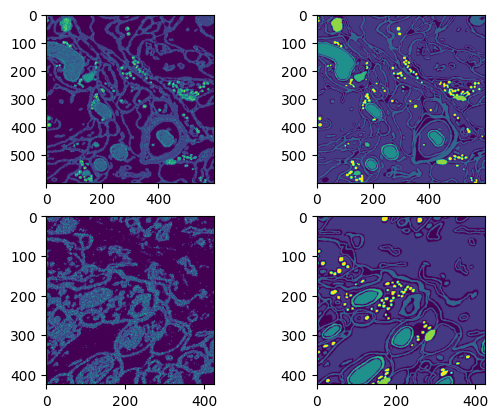

In [9]:
tree = DecisionTreeClassifier()

tree.fit(X_train, Y_train)

predict_and_plot(tree)

Precision train 0.893208086732097
Recall train 0.7687965504630759
F1 train 0.8213325016460807
Precision test 0.3259055287995472
Recall test 0.3240270940976108
F1 test 0.3174902659891745


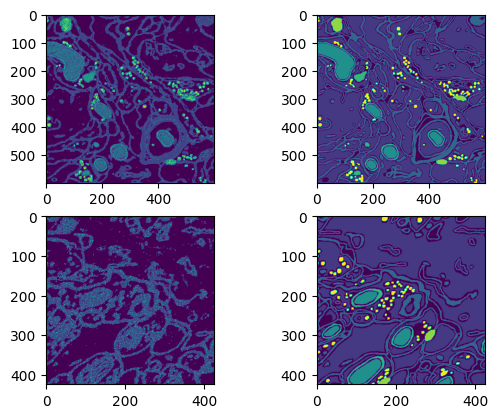

In [10]:
rf = RandomForestClassifier()

rf.fit(X_train, Y_train)

predict_and_plot(rf)

/home/shov/miniconda3/envs/volume/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/shov/miniconda3/envs/volume/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision train 0.27277054399278833
Recall train 0.31973926352562226
F1 train 0.29256365679918633


/home/shov/miniconda3/envs/volume/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision test 0.25888437426195476
Recall test 0.317581529140568
F1 test 0.28084580229558925


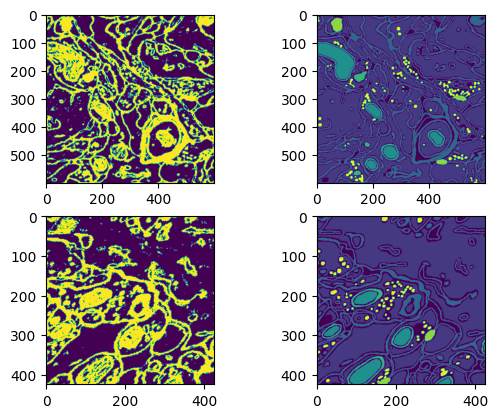

In [11]:
ab = AdaBoostClassifier()

ab.fit(X_train, Y_train)

predict_and_plot(ab)

Precision train 0.8800233853784615
Recall train 0.32180396345197987
F1 train 0.2953864243976094


/home/shov/miniconda3/envs/volume/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision test 0.28996380564105595
Recall test 0.3183612042845941
F1 test 0.28181874605335


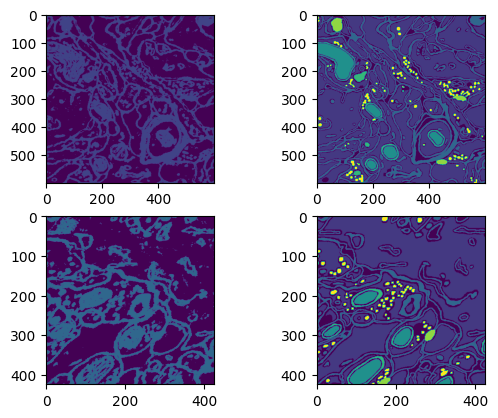

In [12]:
gb = GradientBoostingClassifier()

gb.fit(X_train, Y_train)

predict_and_plot(gb)